# Práctica 4a. Selección de características numéricas.

La selección de carectrísticas es importante ya que permite que el algoritmo de machine learning entrene de una manera más rápida, reduce la complejidad del modelo y facilita su comprensión. Esta técnica se quedará con la información que realmente es importante y desechará el resto.

## Dataset 3.

Este datset es sobre costos médicos personales.

In [1]:
# Importamos las librerías con las que visualizaremos los datos y usemos las técnicas de extracción
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [3]:
# Cargando el dataset
df = pd.read_csv('insurance.csv', sep=',')
# Eliminamos las variables categóricas
del df['sex']
del df['smoker']
del df['region']

df = pd.DataFrame(df)
df.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


### Método de filtro

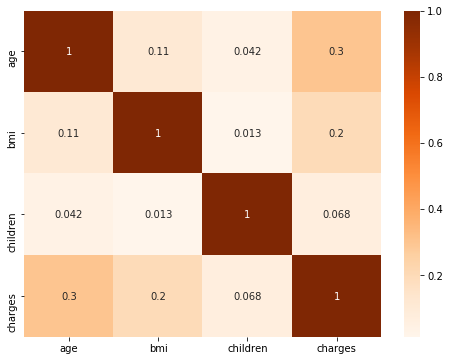

In [5]:
# Graficaremos la matriz de correlación entre las variables para que sea más fácil verlo
plt.figure(figsize=(8,6))
mat_cor = df.corr()
sns.heatmap(mat_cor, annot=True, cmap=plt.cm.Oranges)
plt.show()

In [6]:
#Correlación respecto a la variable de salida o target
cor_target = abs(mat_cor["age"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.5]
relevant_features

age    1.0
Name: age, dtype: float64

Graficamente también podemos notar que no existe una correlación alta entre las variables.

### Método de envoltura (Wrapped method)
#### Eliminación hacia atrás (Backward elimination)

In [7]:
# Separamos las variables dependientes e independiente
X = df.drop("age", 1)
y = df["age"]

In [8]:
# Agregamos columna de 1's a las variables dependientes
X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


children    3.942782e-01
bmi         5.077008e-02
charges     5.533923e-26
const       5.870993e-54
dtype: float64

Las variable 'charges' es la única que tiene un valor p<0.05

In [9]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['charges']


Backward elimination nos indica lo que anteriormente dijimos.

### Eliminación recursiva de características (Recursive Feature Elimination - RFE)

In [10]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 2, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 3 features.
[ True  True False]
[1 1 2]


Características importantes: 'bmi', 'children'.
Ahora necesitamos encontrar el número óptimo de características para las cuales la precisión es la más alta.

In [11]:
#Número de características
nof_list = np.arange(1,3)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 2
Desempeño con 2 características: 0.000420


In [12]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 2)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['bmi', 'children'], dtype='object')


Las dos características son las que anteriormente pusimos.

### Métodos integrados (Embedded method)

In [13]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:1
Desempeño mediante la regularización Lasso: 0.089404


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

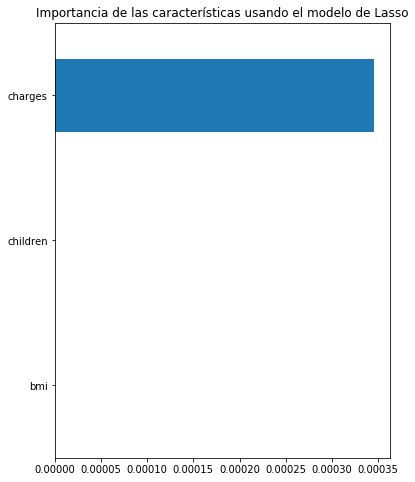

In [18]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 8.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")

La variable 'charges' tiene mayor importancia con LASSO.